In [42]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小

# 初始化多项式的真实权重,并为前四个值分别赋值, y=5+1.2x-(3.4x^2/2!)+(5.6x^3/3!)+ε.ε~N(0,0.1^2)
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 4.3, -2.1, 1.2])

# 生成 n_train+n_test 个随机数。这些数值是输入特征。
features = np.random.normal(size=(n_train + n_test, 1)) # 200*1
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1)) # (200*1)^(1*20)=(200*20)
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # j列除以 [ i行x[i][j]^j/(n-1)!]

# 计算多项式特征与权重的点积，得到形状为 (200,) 的标签向量！！！！！
labels = np.dot(poly_features, true_w) # 求得公式对应的结果！
labels += np.random.normal(scale=0.1, size=labels.shape) # 加入误差，标准差为0.1，方差0.01。ε~N(0,0.1^2)

In [43]:
# NumPy ndarray转换为tensor(x代表数组)(解包赋值不仅仅适用于列表，也适用于任何可迭代对象)
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

# 输出前2个，   前2行，               前2个
features[:2], poly_features[:2, :], labels[:2]

(tensor([[1.3355],
         [0.1554]]),
 tensor([[1.0000e+00, 1.3355e+00, 8.9183e-01, 3.9702e-01, 1.3256e-01, 3.5408e-02,
          7.8814e-03, 1.5037e-03, 2.5103e-04, 3.7251e-05, 4.9751e-06, 6.0403e-07,
          6.7226e-08, 6.9064e-09, 6.5884e-10, 5.8660e-11, 4.8964e-12, 3.8467e-13,
          2.8541e-14, 2.0062e-15],
         [1.0000e+00, 1.5542e-01, 1.2078e-02, 6.2576e-04, 2.4315e-05, 7.5583e-07,
          1.9579e-08, 4.3472e-10, 8.4459e-12, 1.4586e-13, 2.2670e-15, 3.2031e-17,
          4.1487e-19, 4.9601e-21, 5.5066e-23, 5.7057e-25, 5.5426e-27, 5.0674e-29,
          4.3755e-31, 3.5793e-33]]),
 tensor([9.3923, 5.6025]))

In [44]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的[平均损失]"""
    acc = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter: # 分批次遍历，X为一个batch数据，y为对应的label。
        out = net(X) # 10*1
        y = y.reshape(out.shape) # 10*1
        l = loss(out, y) # 10*1
        acc.add(l.sum(), l.numel())
    return acc[0] / acc[1]

# 定义了一个用于训练多项式回归模型的函数 train
# 参数：poly_features[前100*前4], poly_features[后100*前4], labels[1*前100], labels[1*后100]
def train(train_features, test_features, train_labels, test_labels, num_epochs=400):
    '''定义了一个用于训练多项式回归模型的函数 train'''
    loss = nn.MSELoss(reduction='none')
    # 列数！！不是reshape().代表[输入特征的维度]
    input_shape = train_features.shape[-1] # 值为4，代表x对应参数的数量！！
    # 线性模型：不设置偏置，input_shape包含了常数项 b，所以bias不需要。
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0]) # 防止越界访问
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)), batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)), batch_size, is_train=False)
    updater = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, updater)
        # 每训练20轮测试一次
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 4.9869647  4.3345337 -2.0965977  1.1495458]]


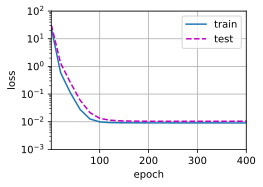

In [45]:
'''三阶多项式函数拟合(正常)'''
# 从多项式特征中选择前4个[维度(列)]，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4], labels[:n_train], labels[n_train:])

weight: [[4.1414003 4.8203845]]


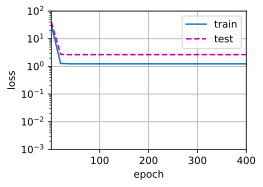

In [46]:
'''线性函数拟合(欠拟合)'''
# 从多项式特征中选择前2个维度，即1和x（欠拟合，用1阶函数模拟3阶）
train(poly_features[:n_train, :2], poly_features[n_train:, :2], labels[:n_train], labels[n_train:])

weight: [[ 4.960224    4.3567386  -1.9193182   1.0450969  -0.6077106   0.1719627
  -0.23812658  0.18546592  0.16497603  0.04597666  0.12902173 -0.01631024
   0.20038919  0.14969647 -0.10761674 -0.04756641 -0.16767263 -0.0651439
   0.07728189  0.2185317 ]]


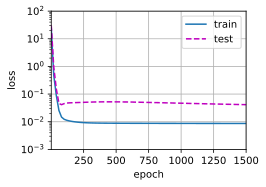

In [47]:
'''高阶多项式函数拟合(过拟合)'''
# 从多项式特征中选取所有维度(过拟合，用19阶函数模拟3阶)
train(poly_features[:n_train, :], poly_features[n_train:, :], 
      labels[:n_train], labels[n_train:], num_epochs=1500)